# Neighborhood-Based Collaborative Filtering
*A Tutorial By Gaurav Chatterjee*

## Collaborative Filtering
**Collaborative Filtering** is a method that services such as Netflix use to determine which products to recommend to their users based on the ratings of other users. There are two methods of doing collaborative filtering. The first is *user-based collaborative filtering*. This method compares a user to other users, ranking similarity based on the ratings they have given, and then suggest an item that a similar user has liked but the current user has not ranked. The second is *item-based collaborative filtering*. This method finds similarities between items based on users who bought items in common, and then suggests items that have a similar consumer.

There are two classes of implementations for collaborative filtering. There are *neighborhood-based* implementations and *model-based* implementations. Neighborhood-based implementations calculate the similarity between two users or items using a similarity function, whereas model-based implementations create a model with training data using one of many possible machine learning algorithms 

## Algorithms
In order to create a neighborhood-based collaborative filtering implementation, we need an algorithm for comparing users or items. These algorithms are similarity functions. Two commonly used similarity functions are Pearson correlation and vector cosine based similarity.

In [29]:
# Let's begin by importing a couple of libraries we will need. These are included in the Anaconda distribution.
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.stats as stats
import scipy.spatial as spat
import networkx as nx

We need a data set with users and ratings to operate on. Let's use the Twitter data that we have previously worked with. In doing so, the account represent both the user and the item. We will be choosing an account and then recommending other accounts to follow. We can use the pandas function .read_csv to generate a pandas DataFrame containing the edges.

In [2]:
# import data from csv to pandas DataFrame
edges = pd.read_csv("edges.csv")
print edges.head()

       screen_name         friend
0  realDonaldTrump          Trump
1  realDonaldTrump      TrumpGolf
2  realDonaldTrump  TiffanyATrump
3  realDonaldTrump  IngrahamAngle
4  realDonaldTrump     mike_pence


Now, we must convert this data into a matrix format that we can use. We need a column with all the users in the `screen_name` row, and then we need one column for all the users in the `friend` column. A value of 1 will represent that the account in the users column has another user as friend. The pandas method get_dummies can help us us generate this matrix. Although we can store the data in a dense matrix, since we have a large amout of data and we have a lot of zeroes, we will store this data in a sparse matrix. Since we are creating this matrix from scratch, we will be using the `scipy.sparse.dok_matrix` type, which stands for Dictionary of Keys matrix. We will also be keeping two dictionaries to keep track of the relationship between the the rows and columns of the matrix to the screen names and friends from our pandas DataFrame.

In [3]:
def table_to_matrix(table):
    '''Takes a pandas DataFrame of screen names and friends and returns a sparse Dictionary of Keys matrix,
    along with two dictionaries with labels for each row and column of the matrix
    '''
    groups = table.groupby("screen_name")
    frdct = len(table.groupby("friend")) # count of all of the unique usernames in the friend column
    mat = sp.dok_matrix((len(groups), frdct)) # initialized to all zeros
    sncode = {} # keep track of row indices of screen names
    frdcode = {} # keep track of column indices of friends
    curr_sn = 0
    curr_frd = 0
    for sn, frds in groups: # iterate through groups (grouped by screen_name)
        sncode[sn] = curr_sn
        curr_sn += 1
        for frd in frds["friend"]: # iterate through friends of this screen_name and modify matrix
            if not frd in frdcode:
                frdcode[frd] = curr_frd
                curr_frd += 1
            mat[sncode[sn], frdcode[frd]] = 1
    sncode = {num: sn for sn, num in sncode.iteritems()}
    frdcode = {num: frd for frd, num in frdcode.iteritems()}
    return mat, sncode, frdcode

In [4]:
# Assign matrix and dicts to variables
frd_mat, sncode, frdcode = table_to_matrix(edges)
print frd_mat.shape
print sncode[169]
print frdcode[1094]

(179, 12403)
realDonaldTrump
seanhannity


Now that we have our data in a matrix format, we are ready to find similarities between users. The two algorithms mentioned earlier, Pearson correlation and vector cosine based similarity, can both be implemented using scipy. The function for Pearson correlation is `scipy.stats.pearsonr()`, and the function for vector cosine based similarity is `scipy.spatial.distance.cosine()`. The scipy.spatial.distance library has a variety of other functions that can be used to calculate similarity as well.

Before we go ahead and use these algorithms, it is important to learn how they are determining the similarity between two users. I would suggest taking a look at the equations and see what they are doing. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#For_a_sample) is a measure of how closely the data points resemble a line, ranging from -1 to 1. [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity#Definition) is a measure based on the cosine of the angle between two vectors, also ranging from -1 to 1.


## Item-Based Collaborative Filtering
Let's go ahead and try these two methods to find some recommendations of accounts for users to follow, using item-based collaborative filtering.

In [5]:
def recommendation(frd_mat, fn):
    itemct = frd_mat.shape[1] # we created our matrix with the "items" on the columns
    item_mat = sp.dok_matrix((itemct, itemct)) # this will show us the relationship between "items"
    # now we visit each cell in our item matrix and fill in the relationship
    for i in xrange(itemct):
        for j in xrange(itemct):
            item_mat[i,j] = fn(frd_mat[:,i].todense(), frd_mat[:,j].todense())[0]
    return item_mat

Running the above code would take a very long time if we ran it on our `frd_mat` matrix. That matrix has 12403 columns, which would mean that it would be iterating through 12,403 × 12,403 cells, or 153,834,409 iterations. Let's truncate our items to the first 200 columns to reduce the number of iterations. This way, we'll only be dealing with 40,000 iterations. Running the above function on this truncated matrix will only show us the similarities between the first 200 "items."

In [6]:
frd_mat_trunc = frd_mat[:,:200]

pr = recommendation(frd_mat_trunc, stats.pearsonr)
print pr.todense()

[[ 1.          1.          1.         ..., -0.00561798 -0.00796743
  -0.00561798]
 [ 1.          1.          1.         ..., -0.00561798 -0.00796743
  -0.00561798]
 [ 1.          1.          1.         ..., -0.00561798 -0.00796743
  -0.00561798]
 ..., 
 [-0.00561798 -0.00561798 -0.00561798 ...,  1.          0.70511773  1.        ]
 [-0.00796743 -0.00796743 -0.00796743 ...,  0.70511773  1.          0.70511773]
 [-0.00561798 -0.00561798 -0.00561798 ...,  1.          0.70511773  1.        ]]


Great! Now that we have a relationship matrix, let's interpret it.

Let's choose a user in our table and find the most similar users.

In [7]:
def top_n(rel_mat, row_num, n=5):
    row = np.array(rel_mat[row_num].todense()).squeeze()
    row[row_num] = -2.0 # this will always be 1.0 because it is compared to itself. We set it to -2.0 so that it won't come up
    # when we use argmax to find the largest values
    indices = []
    for i in xrange(n):
        high_index = row.argmax()
        indices.append(high_index)
        row[high_index] = -2.0
    return indices

In [8]:
idxs = top_n(pr, 110)
print frdcode[110]
print [frdcode[i] for i in idxs]

realDonaldTrump
['CNNnewsroom', 'Bakari_Sellers', 'ChrisCuomo', 'CNNOriginals', 'NoahGrayCNN']


At first, this may seem like a surprising result. Shouldn't we be getting results related to Donald Trump if we try to find accounts similar to his? However, if we look at the sample of data that we used, we realize that these results *are* similar to Donald Trump. Since we truncated the data, we lost accounts like Mike Pence and Sean Hannity that might have been more similar to Trump. Instead, we get results related to politics, and more specifically, to CNN. Keep in mind that we classified these accounts as similar solely based on the people who followed them.

What if we try creating our relationship matrix with cosine similarity instead?

In [9]:
def cosine_similarity(a,b):
    return (1 - spat.distance.cosine(a,b),)

cr = recommendation(frd_mat_trunc, cosine_similarity)
print cr.todense()

[[ 1.          1.          1.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  1.          0.70710678  1.        ]
 [ 0.          0.          0.         ...,  0.70710678  1.          0.70710678]
 [ 0.          0.          0.         ...,  1.          0.70710678  1.        ]]


Let's get the top 5 similar users for the same user as before:

In [10]:
idxs = top_n(cr, 110)
print frdcode[110]
print [frdcode[i] for i in idxs]

realDonaldTrump
['CNNnewsroom', 'Bakari_Sellers', 'CNNOriginals', 'NoahGrayCNN', 'ChrisCuomo']


We get the same results, but in a different order.

If we were to use item-based collaborative, we would suggest these five accounts to users who followed realDonaldTrump.

Let's visualize these recommendations. First we'll construct a directed graph using networkx.

In [40]:
def gen_graph(rel_mat):
    G = nx.DiGraph()
    for i in xrange(rel_mat.shape[0]):
        sims = [(i,idx) for idx in top_n(rel_mat, i)]
        for tup in sims:
            G.add_edge(*tup)
    return G

pG = gen_graph(pr)
cG = gen_graph(cr)

print pG.number_of_nodes()
print pG.number_of_edges()
print cG.number_of_nodes()
print cG.number_of_edges()

200
1000
200
1000


Now we can visualize this graph using matplotlib.

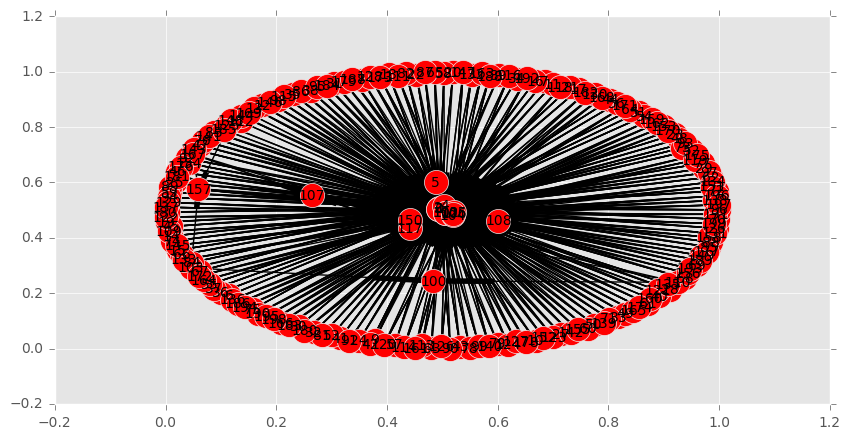

In [44]:
nx.draw_networkx(pG, node_size=300, font_size=10)

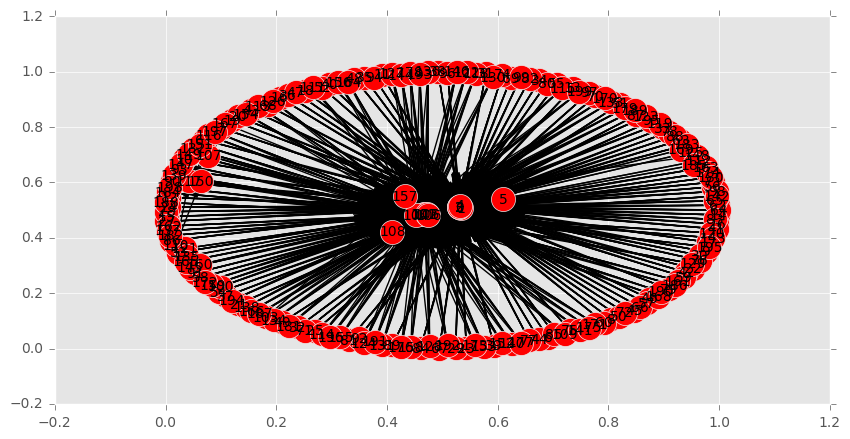

In [45]:
nx.draw_networkx(cG, node_size=300, font_size=10)

These visualizations are somewhat difficult to see due to the way matplotlib shows arrows and labels nodes. However, we can see that the ring of nodes all point to a few nodes in the center of the graph, including 5, 108, 107, 150, 100, 117, 157, and others.

In [46]:
central = [5, 108, 107, 150, 100, 117, 157]
print [frdcode[num] for num in central]

['NYC_DealFinder', 'DavidChalian', 'NewDay', 'ChrisCuomo', 'CNNnewsroom', 'Bakari_Sellers', 'donlemon']


These will be some of the most recommended users in the truncated relation matrix.

## User-Based Collaborative Filtering
The first steps of user-based collaborative filtering are the same as item-based collaborative filtering. We need a relationship matrix of the items. We already have this matrix.

The next step is to find similarities between users. To do this, we need to consider the people that the user follows.

In [120]:
def user_sim(data, rel_mat):
    usr_mat = sp.dok_matrix(data.shape)
    for i in xrange(usr_mat.shape[0]):
        for j in xrange(usr_mat.shape[1]):
            if data[i,j] == 1:
                usr_mat[i,j] = 0
            else:
                frd_top_idx = top_n(rel_mat, j) # indices of the top 5 similar "items" to this one
                frd_top_sim = rel_mat[j, frd_top_idx] # similarities at those indices
                curr_follow =    data[i, frd_top_idx] # whether or not this user followed those
                usr_mat[i,j] = curr_follow.dot(frd_top_sim.T).sum()/frd_top_sim.sum() # combination of two above factors
    return usr_mat

Now we can create the matrices we need.

In [131]:
usr_sim_mat_pr = user_sim(frd_mat_trunc, pr)
print usr_sim_mat_pr
usr_sim_mat_cr = user_sim(frd_mat_trunc, cr)
print usr_sim_mat_cr

  (52, 167)	0.174909281857
  (94, 103)	0.214490900969
  (52, 150)	0.207196471819
  (52, 117)	0.207196471819
  (16, 103)	0.214490900969
  (16, 148)	0.167466907971
  (16, 167)	0.174909281857
  (52, 167)	0.176235222545
  (94, 103)	0.217482258674
  (52, 150)	0.207347521885
  (52, 117)	0.207347521885
  (16, 103)	0.217482258674
  (16, 148)	0.169520847199
  (16, 167)	0.176235222545


As we can see, these matrices are quite sparse due to the small size of the data that we ran it on. This highlights the fact that when we do not have a lot of data, item-based collaborative filtering is better at generating recommendations than user-based collaborative filtering.

Let's see which users were recommended.

In [155]:
users_with_good_data = [52,94,16] # from printing the matrices above, we see that these are the only ones with suggestions
for user in users_with_good_data:
    print sncode[user] + ":",
    recs = usr_sim_mat_pr[user]
    for key in recs.keys():
        print frdcode[key[1]],
    print

LGlick1: ChrisCuomo Bakari_Sellers brianstelter
TNGCJ: NBCNews
CureCancerNow: brianstelter NBCNews jaketapper


And there we have it!

## Acknowledgements
Aside from relying heavily on Wikipedia for preliminary knowledge on the subject, Salem Marafi's [blog post](http://www.salemmarafi.com/code/collaborative-filtering-with-python/) on collaborative filtering in Python was extremely helpful in fleshing out code.